In [1]:
import tensorflow as tf
from modules.metropolis import *
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from collections import Counter

@dataclass
class TestProblem(QFTProblem):
    size: tuple[float, float] = (10, 100)

    def volume(self) -> npt.NDArray:
        return np.array(self.size)

    def get_amplitude(self, x_n: tf.Tensor, ns: npt.NDArray, training: bool = False) -> tf.Tensor:
        mask = tf.sequence_mask(ns, maxlen = x_n.shape[-2])

        mask = tf.cast(mask, x_n.dtype)
        masked_sin = tf.where(mask > 0, tf.sin(x_n[:, :, 0]) * tf.sin(x_n[:, :, 1] / 20), tf.ones_like(x_n[:, :, 0])) # type: ignore
        profile = tf.pow(tf.reduce_prod(masked_sin, axis=1), 2)

        ns = tf.cast(ns, x_n.dtype) # type: ignore

        return profile * np.exp(-ns / 10.) / np.power(np.prod(self.volume()), ns / 2.) * (0.1 + ns)

In [2]:
test_problem = TestProblem()

metropolis = FockSpaceMetropolis(test_problem, 5, rng=np.random.default_rng(0))

x_n, ampilitude = metropolis.new_configuration(2, 2)
print("initial\n", x_n)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)
            
x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_changed = metropolis.change_positions(x_n)
print("change position\n", x_changed)

x_step, _ = metropolis.step(x_n, ampilitude)
print("step one\n", x_step)
x_n, _ = metropolis.new_configuration(2, 0)
print("initial\n", x_n)

x_remove = metropolis.remove_one(x_n)
print("remove one\n", x_remove)

x_add = metropolis.add_new(x_n)
print("add new\n", x_add)


initial
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 8.13270239, 91.27555773],
        [ 6.06635776, 72.9496561 ],
        [ 5.43624991, 93.50724238]],

       [[ 8.15853554,  0.27385002],
        [ 8.57404277,  3.35855753],
        [ 7.29655446, 17.56556206],
        [ 8.63178922, 54.14612202],
        [ 2.99711891, 42.26872212]]]), n_s=array([2, 2], dtype=int32))
add new
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 0.28319671, 12.42832765],
        [ 6.06635776, 72.9496561 ],
        [ 5.43624991, 93.50724238]],

       [[ 8.15853554,  0.27385002],
        [ 8.57404277,  3.35855753],
        [ 6.70624415, 64.71895116],
        [ 8.63178922, 54.14612202],
        [ 2.99711891, 42.26872212]]]), n_s=array([3, 3], dtype=int32))
remove one
 ConfigurationBatch(x_n=array([[[ 6.36961687, 26.97867138],
        [ 0.40973524,  1.65276355],
        [ 8.13270239, 91.27555773],

In [2]:
import modules.metropolis as metro
import importlib
importlib.reload(metro)

batch = 32
n_max = 10

test_problem = TestProblem()
test_metropolis = metro.FockSpaceMetropolis(test_problem, n_max, rng=np.random.default_rng(0))

def metropolis_step(metropolis: FockSpaceMetropolis, batch = 32, n_init = 5):
    x_recent, amplitude_recent = metropolis.new_configuration(batch, n_init)
    while True:
        x_recent, amplitude_recent = metropolis.step(x_recent, amplitude_recent)
        yield x_recent.x_n, x_recent.n_s

dataset = tf.data.Dataset.from_generator(
    lambda: metropolis_step(test_metropolis, batch = batch),
    output_signature = (
        tf.TensorSpec(shape=(batch, n_max, 2), dtype=tf.float32, name="features"), # type: ignore
        tf.TensorSpec(shape=(batch), dtype=tf.int32) # type: ignore
    )
)


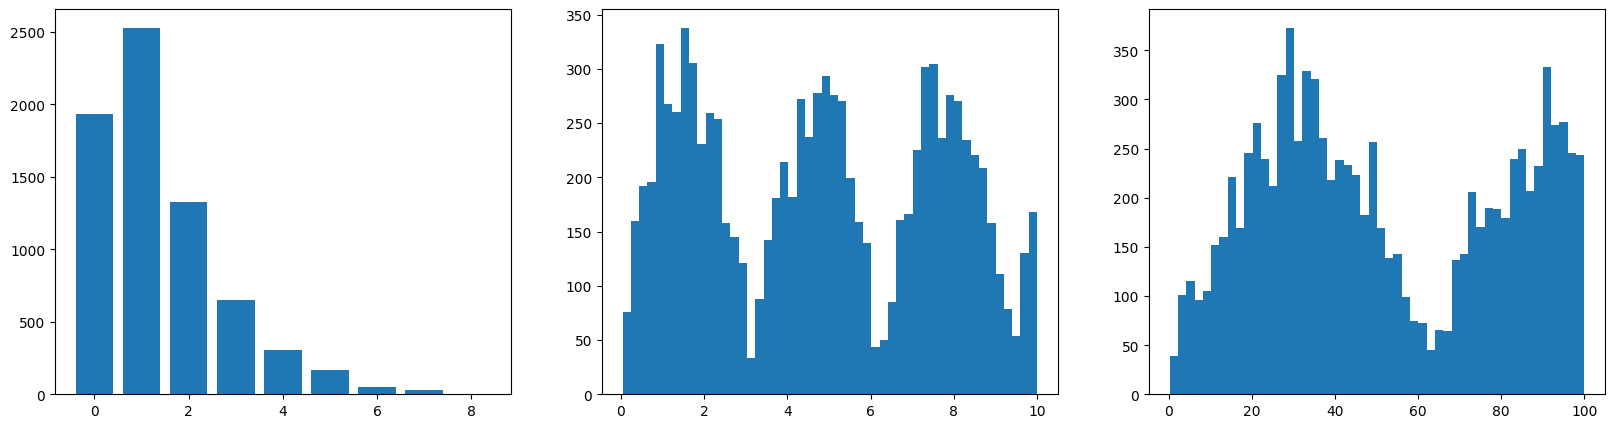

In [3]:
from collections import Counter

configurations = dataset.unbatch().skip(3000).take(7000).cache()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50)
axes[2].hist(positions_2, bins=50);

In [5]:
tfds.benchmark(dataset.take(10000), batch_size = batch)


************ Summary ************



0it [00:00, ?it/s]

Examples/sec (First included) 15893.58 ex/sec (total: 320032 ex, 20.14 sec)
Examples/sec (First only) 77.03 ex/sec (total: 32 ex, 0.42 sec)
Examples/sec (First excluded) 16226.76 ex/sec (total: 320000 ex, 19.72 sec)


,duration,num_examples,avg
first+lasts,20.135933,320032,15893.576999
first,0.415424,32,77.029771
lasts,19.720509,320000,16226.761610


In [6]:
with tf.GradientTape() as g2:
    with tf.GradientTape() as g:
        x_n, n_s = next(iter(configurations.batch(1).skip(40))) # type: ignore

        x_n = tf.Variable(x_n)
        print(x_n, n_s)

        value = test_problem.get_amplitude(x_n, n_s) # type: ignore

    gradient = g.gradient(value, x_n)

hessian = g2.jacobian(gradient, x_n)
# laplacian = tf.linalg.trace(laplacian)
laplacian = tf.einsum('bpibpi->bpi', hessian)

print("y", value)
print("gradient", gradient)
print("laplacian", laplacian)

<tf.Variable 'Variable:0' shape=(1, 10, 2) dtype=float32, numpy=
array([[[ 5.0902042 , 72.595436  ],
        [ 8.687788  , 43.252575  ],
        [ 0.95789915,  8.690153  ],
        [ 0.83288276, 89.49227   ],
        [ 8.087362  , 43.382     ],
        [ 1.1243632 , 23.481735  ],
        [ 9.022893  , 62.04052   ],
        [ 5.9924383 , 55.55923   ],
        [ 8.205903  , 53.68986   ],
        [ 6.432432  , 77.57588   ]]], dtype=float32)> tf.Tensor([2], shape=(1,), dtype=int32)
y tf.Tensor([0.00010165], shape=(1,), dtype=float32)
gradient tf.Tensor(
[[[-8.0685510e-05  1.9141149e-05]
  [-2.2399958e-04 -6.8329973e-06]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00]]], shape=(1, 10, 2), dtype=float32)
laplacian tf.Tensor(
[[[-1.7127609e-04  1.2939470e-06]
  [ 4.3509703

In [7]:
x0 = 4.85924769
x1 = 23.90258908

print("y", np.power(np.sin(x0) * np.sin(x1 / 20), 2) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx0", np.sin(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("dy/dx1", 1 / 20 * np.sin(x0) ** 2 * np.sin(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx0^2", 2 * np.cos(2 * x0) * np.sin(x1 / 20) ** 2 * np.exp(-0.1) / np.sqrt(1000) * 1.1)
print("d^2y/dx1^2", 1 / 200 * np.sin(x0) ** 2 * np.cos(2 * x1 / 20) * np.exp(-0.1) / np.sqrt(1000) * 1.1)

y 0.026654735548713143
dy/dx0 -0.007885733618981039
dy/dx1 0.0010512547138865212
d^2y/dx0^2 -0.05214298429068455
d^2y/dx1^2 -0.00011254309365187722


In [ ]:
from importlib import reload
import modules.hamiltonians.hamiltonian_terms as terms
reload(terms)

kinetic_term = terms.KineticTerm(0.5)

x_n, n_s = next(iter(configurations.batch(4).skip(20))) # type: ignore
x_n: tf.Tensor = tf.Variable(x_n) # type: ignore

print("kinetic term")
print(kinetic_term.local_energy(x_n, n_s, test_problem))

chemical_potential = terms.ExternalPotential.chemical_potential(1)

print("Chemical potential")
print(chemical_potential.local_energy(x_n, n_s, test_problem))

In [10]:
import keras
import modules.ansatz_nn as ansatz_nn
from modules.hamiltonians.hamiltonian_terms import *
import importlib
importlib.reload(ansatz_nn)

input_dim = 2

ds1 = ansatz_nn.DeepSets(16, 2, 2, input_dim=input_dim)
ds2 = ansatz_nn.DeepSets(16, 2, 2, input_dim=input_dim)

test_model = ansatz_nn.QFTNeuralNet(np.array([10, 100]), ds1, ds2)
dataset = metro.make_dataset(test_model, 32, 10, 5)

hamiltonian = KineticTerm(0.5)


In [6]:
import os
import datetime

%load_ext tensorboard
%reload_ext tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 204880), started 1:53:21 ago. (Use '!kill 204880' to kill it.)

In [11]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-3,
    decay_steps = 5,
    decay_rate=0.95,
    staircase=True
)

test_model.compile(
    optimizer = tf.keras.optimizers.Adam(lr_schedule),
    hamiltonian = hamiltonian,
)

history = test_model.fit(
    dataset.skip(500).take(1000),
    epochs = 10,
    callbacks = [tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)]
)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - energy: 0.0696 - loss: 0.0696 - mean_particle_number: 8.9564
Epoch 2/10


c:\Users\marcr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - energy: 0.0703 - loss: 0.0703 - mean_particle_number: 8.9750
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - energy: 0.0686 - loss: 0.0686 - mean_particle_number: 8.9825
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - energy: 0.0687 - loss: 0.0687 - mean_particle_number: 8.8289
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - energy: 0.0666 - loss: 0.0666 - mean_particle_number: 8.9101
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - energy: 0.0683 - loss: 0.0683 - mean_particle_number: 8.9515
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - energy: 0.0690 - loss: 0.0690 - mean_particle_number: 8.8850
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - energy: 0.0680 - loss: 0.0680 - mean_particle_number: 8.9118
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - energy: 0.0710 - loss: 0.0710 - mean_particle_number: 8.9834
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - energ

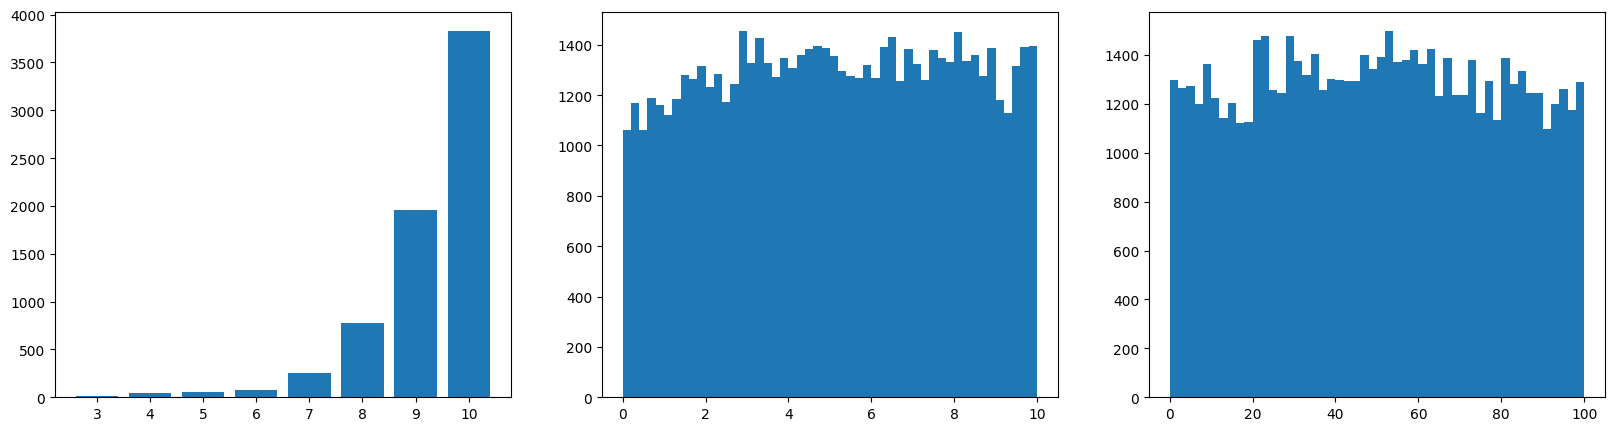

In [12]:
configurations = dataset.skip(500).unbatch().take(7000).cache()
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

n_values = list(map(lambda x_n: x_n[1].numpy(), configurations))
n_counter = Counter(n_values)
axes[0].bar(n_counter.keys(), n_counter.values())

positions_1 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 0], configurations))).ravel()
positions_2 = np.concatenate(list(map(lambda x_n: x_n[0][:x_n[1], 1], configurations))).ravel()

axes[1].hist(positions_1, bins=50)
axes[2].hist(positions_2, bins=50);